# Chordialement

Chord diagrams ('circos') can be used to visualize a very specific type of dataset. The data should contain observations that fall in discrete categories and have pairwise, but ideally bidirectional, association between observations. Say a dataset containing information about twins' political opinions, or couples favourite musical genre.  

In most cases, these plots don't bring more information than a triangular [jointplot](https://seaborn.pydata.org/generated/seaborn.jointplot.html). But they are arguably prettier and allow to show individual observation. It can also be easier to add more information to the plot (by modifying the width & color of the link for example). 

This package is another attempt to make them easy to plot. Similar tentatives include [Circos](http://circos.ca), [Chord](https://pypi.org/project/chord/), [Bokeh](https://bokeh.org) and [plotly](https://plotly.org). I wanted a pure python one, based on matplotlib, and personalizable so this is it. 

In [1]:
import pandas as pd
import pyreadstat
from chordialement import chord_diagram

In [30]:
df = pd.read_spss('Uminn_twinsvy.sav')
df = df[df.complete_pair == "complete pair"].copy()
df["FAMID"] = df.FAMID.astype(int)

In [31]:
df["Qq49_order"] = df.Qq49.map({'Extremely liberal': 0,
                                    'Liberal': 1,
                                    'Slightly liberal': 2,
                                    'Moderate/Middle of the road': 3,
                                    'Slightly conservative': 4,
                                    'Conservative': 5,
                                    'Extremely Conservative': 6})
df = df.dropna(subset=["Qq49", "Qq75"])
df = df.sort_values(by="Qq49_order").reset_index()
df["number_twin"] = df.FAMID.map(df.FAMID.value_counts())
df = df[df.number_twin == 2].copy()


In [95]:

import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
from matplotlib import colors
from matplotlib.lines import Line2D

import warnings
import seaborn as sns
import math
import numpy as np
import pandas as pd


def deCasteljau(b, t):
    N = len(b)
    a = np.copy(b)
    for r in range(1, N):
        a[:N-r, :] = (1-t)*a[:N-r, :] + t*a[1:N-r+1, :]
    return a[0, :]


def BezierCv(b, nr=5):
    t = np.linspace(0, 1, nr)
    return np.array([[deCasteljau(b, t[k]),
                      deCasteljau(b, t[k+1])] for k in range(nr-1)])


def position_circle(x, radius=1):
    """ Return the x,y coordinate of the point at
        angle (360*x)°, in the circle of radius "radius"
        and center (0, 0)
    """
    return np.array([radius*math.cos(x*2*math.pi),
                     radius*math.sin(x*2*math.pi)])


def linear_gradient(start, end, n=10):
    """ Return a gradient between start and end,
        with n elements.
    """
    gradients = np.zeros((len(start), n))
    for i in range(len(start)):
        gradients[i, :] = np.linspace(start[i], end[i], num=n)
    return np.transpose(gradients)


def linear_gradient_color(c1, c2, n=10):
    """ Return a gradient between the two color c1 & c2
    """
    return linear_gradient(colors.to_rgba(c1), colors.to_rgba(c2), n=n)


def draw_chord(A, B, ax=None, color_start="b", color_end="r",
               precision=1000, **kwargs):
    """ Draw a Bezier curve between two points """
    d = np.linalg.norm(np.array(A) - np.array(B))

    # Depending on the distance between the points
    # the Bezier curve parameters change
    b = [A, A/(1 + d), B/(1 + d), B]
    bz = BezierCv(b, nr=precision)

    lc = mcoll.LineCollection(bz,
                              colors=linear_gradient_color(color_start,
                                                           color_end,
                                                           n=precision), **kwargs)
    ax.add_collection(lc)


def draw_arc_circle(start, end, color="b", radius=1, ax=None,
                    thickness=0.1, precision=1000, **kwargs):
    ts = np.linspace(start, end, precision)
    poly_nodes = ([position_circle(t, radius=radius) for t in ts] +
                  [position_circle(t, radius=radius+thickness)
                   for t in ts[::-1]])
    x, y = zip(*poly_nodes)
    ax.fill(x, y, color=color, **kwargs)


def add_text_circle(x, txt, radius=1, ax=None, **kwargs):
    """ Add text on the border of the circle, in the right orientation """
    ax.text(*position_circle(x, radius=radius),
            txt, rotation=(360*x - 180 if 0.25 < x < 0.75 else 360*x),
            ha='right' if 0.75 > x > 0.25 else 'left',
            va='top' if 0.75 > x > 0.25  else 'bottom',
            rotation_mode='anchor', **kwargs)


def order_data(data, categories, pairs):
    """
    Return a correctly ordered dataframe, ready to be plotted in chord format
    @ Args:
    data: pd.DataFrame() to reorder, with a column 
    `categories` and a column `pair`
    """
    df, mapcat = process_data(data, categories, pairs)
    df["associate_cat_order"] = df.apply(
        lambda r: (len(mapcat)+r["nbcat"]-r["associate_nbcat"]) % len(mapcat)
        + (len(mapcat)//2+1 if r["nbcat"]==r["associate_nbcat"] else 0.5),
        axis=1)
    df["sort_order"] = df.apply(
        lambda r: (r["idx"] if r["nbcat"] <= r["associate_nbcat"]
                   else -r["associate"]),
        axis=1)
    df = df.sort_values(by=["nbcat", "associate_cat_order", "sort_order"])
    return df, mapcat


def process_data(data, categories, pairs, space_cat=None):
    """
    Process the dataframe so that it can be plotted in chord format
    @ Args:
    data: pd.DataFrame() to reorder, with a column 
    `categories` and a column `pair`
    """
    if space_cat is None:
        space_cat = categories
    df = data[list(set([categories, pairs, space_cat]))].copy()
    catunique = df[categories].unique()
    mapcat = dict(zip(catunique, range(len(catunique))))
    df["nbcat"] = df[categories].map(mapcat).astype(int)
    df["idx"] = df.index
    pairorder = df.sort_values(by=pairs)
    pairmap = dict(zip(list(pairorder.index[0::2]) +
                       list(pairorder.index[1::2]),
                       list(pairorder.index[1::2]) +
                       list(pairorder.index[0::2])))
    df["associate"] = df.index.map(pairmap)
    df["associate_nbcat"] = df.associate.map(df.nbcat)
    df["associate"] = df.index.map(pairmap)
    df["associate_nbcat"] = df.associate.map(df.nbcat)
    df["nbcat_spacing"] = df[space_cat].astype('category').cat.codes
    df["nbcat_dbl"] = df.apply(lambda r: (r[space_cat], r[categories]),
                               axis=1).astype('category').cat.codes
    df["associate_nbcat_dbl"] = df.associate.map(df.nbcat_dbl)
    return df, mapcat


def chord_diagram(categories, pair,
                  data=None, ax=None, palette=sns.color_palette(),
                  layout_args={}, text_args={}, chord_args={}):
    """ Draw a chord diagram. 
        @ Args
        - categories: Categories of each individual.
        Either a list or a column name if `data` is not None. 
        - pair: For each individual identifies the pair it's in.
        Every value should appear twice. Either a list or a column
        name if `data` is not None.
        - data: dataset containing the columns `categories` and `pair`
        - ax: matplotlib ax object
        - palette: seaborn palette
        - layout_args: dict arguments for the layout, include:
            * 'spacing' (default 0): space between the categories
            * precision_chord: precision to plot the chord,
                               higher = better but slower.
            * precision_circle: same for the circles
            * subcircle: presence or not of a subcircle (see examples)
            * thickness_circle, thickness_subcircle: width of the circle / subcircle (default 0.1)
            * radius_circle, radius_subcircle: radii of both circles
            * internal_chords: Plot or not the internal chords (default `False`)
            * radius_text: radius of the text
            * no_chords: Don't plot the chords (good for testing, default `False`)
            * inverted_grad: Inverse the gradient on the chords (default `True`)
            * circle_args / subcircle_args: dict, default `{}`, additional arguement for ax.fill
    """

    if data is None:
        data_copy = pd.DataFrame()
        data_copy["cat"] = categories
        data_copy["pair"] = pair
        categories = "cat"
        pair = "pair"
    else:
        data_copy = data.copy()
        
    if not np.all(data_copy[pair].value_counts() == 2): 
        raise TypeError("Every value in the `pair` column "
                        "should appear exactly twice")
        
    df, mapcat = order_data(data_copy, categories, pair)
    data_copy = data_copy.reindex(df.index)
    plot_diagram(df, mapcat, ax, palette, layout_args,
                 text_args, chord_args)
    return data_copy
    
def colored_chords(data, pair, categories, hue, ax=None, 
                   palette=sns.color_palette(), legend=True,
                   layout_args={}, text_args={}, chord_args={}, 
                   legend_args={}):
    """ Plot a chord diagram from the data. Don't reorder the data. 
        @ Args
        - categories: Categories of each individual.
        Either a list or a column name if `data` is not None. 
        - hue: Color associated to each individual.
        Either a list or a column name if `data` is not None. 
        - pair: For each individual identifies the pair it's in.
        Every value should appear twice. Either a list or a column
        name if `data` is not None.
        - data: dataset containing the columns `categories` and `pair`
        - ax: matplotlib ax object
        - palette: seaborn palette
        - layout_args: dict arguments for the layout, include:
            * 'spacing' (default 0): space between the categories
            * precision_chord: precision to plot the chord,
                               higher = better but slower.
            * precision_circle: same for the circles
            * subcircle: presence or not of a subcircle (see examples)
            * thickness_circle, thickness_subcircle: width of the circle / subcircle (default 0.1)
            * radius_circle, radius_subcircle: radii of both circles
            * internal_chords: Plot or not the internal chords (default `False`)
            * radius_text: radius of the text
            * no_chords: Don't plot the chords (good for testing, default `False`)
            * inverted_grad: Inverse the gradient on the chords (default `True`)
            * circle_args / subcircle_args: dict, default `{}`, additional arguement for ax.fill
    """
    if text_args == {}:
        text_args['visible'] = False
    if 'radius_text' not in layout_args:
        layout_args['radius_text'] = 0
    if 'inverted_grad' not in layout_args:
        layout_args['inverted_grad'] = False
    if 'subcircle' not in layout_args:
        layout_args['subcircle'] = False
    df, mapcat = process_data(data, hue, pair, space_cat=categories)
    ax = plot_diagram(df, mapcat, ax, palette=palette,
                 layout_args=layout_args, text_args=text_args,
                 chord_args=chord_args)
    if legend:
        if 'linewidth' not in legend_args:
            legend_args['linewidth'] = 4
        if 'bbox_to_anchor' not in legend_args:
            legend_args['bbox_to_anchor']=(1.2,1)
        if 'loc' not in legend_args:
            legend_args['loc'] = 'upper right'

        custom_lines = [Line2D([0], [0], color=palette[mapcat[c]],
                               lw=legend_args['linewidth']) for c in mapcat]
        del legend_args['linewidth']
        ax.legend(custom_lines, [c for c in mapcat], **legend_args)

    
    
    
def plot_diagram(df, mapcat, ax=None, palette=sns.color_palette(),
                 layout_args={}, text_args={}, chord_args={}):
    """ Internal function, plot chord diagram 
    """
    if 'spacing' not in layout_args:
        layout_args['spacing'] = 0
    if 'precision_chord' not in layout_args:
        layout_args['precision_chord'] = 100
    if 'precision_circle' not in layout_args:
        layout_args['precision_circle'] = 100
    if 'thickness_circle' not in layout_args:
        layout_args['thickness_circle'] = 0.1
    if 'subcircle' not in layout_args:
        layout_args['subcircle'] = True
    if 'radius_subcircle' not in layout_args:
        layout_args['radius_subcircle'] = 1.14
    if 'radius_circle' not in layout_args:
        layout_args['radius_circle'] = 1.02
    if 'thickness_subcircle' not in layout_args:
        layout_args['thickness_subcircle'] = 0.1
    if 'internal_chords' not in layout_args:
        layout_args['internal_chords'] = False
    if 'radius_text' not in layout_args:
        layout_args['radius_text'] = max(layout_args['thickness_subcircle'] 
                                         + layout_args['radius_subcircle'],
                                         layout_args['thickness_circle'] 
                                         + layout_args['radius_circle']) + 0.1
    if 'no_chords' not in layout_args:
        layout_args['no_chords'] = False
    if 'inverted_grad' not in layout_args:
        layout_args['inverted_grad'] = True
    if 'circle_args' not in layout_args:
        layout_args['circle_args'] = {}
    if 'subcircle_args' not in layout_args:
        layout_args['subcircle_args'] = {}


    cat_jump = list(np.where(df.nbcat_spacing.values[:-1] != df.nbcat_spacing.values[1:])[0])
    x = 0
    positions = []
    for i in range(len(df)):
        positions.append(x)
        if i in cat_jump:
            x += layout_args['spacing']
        x += (1 - layout_args['spacing']*(len(cat_jump)+1))/(len(df))
    df["position"] = positions
    df["associate_position"] = df.associate.map(df.position)

    nbcategories = df.nbcat.nunique()
    if len(palette) < nbcategories:
        warnings.warn("Not enough colors in the palette ({} needed), switching "
                      "to Seaborn husl palette.".format(nbcategories))
        palette = sns.color_palette("husl", nbcategories)

    if ax is None:
        _, ax = plt.subplots(figsize=(8, 8))
        ax.axis('off')

    nb_to_name_cat = {mapcat[k]:k for k in mapcat}
    positions = df.position.values
    tgt_cat = df.nbcat_dbl.values
    idxs = np.where(tgt_cat[:-1] != tgt_cat[1:])[0]
    start_categorie = [0] + list(positions[idxs+1])
    end_categorie = list(positions[idxs]) + [positions[-1]]
    vcat = df.nbcat
    cats = [vcat[0]] + list(vcat.iloc[idxs+1])

    for s, e, c in zip(start_categorie, end_categorie, cats):
        draw_arc_circle(s - 0.5/len(df), e + 0.5/len(df), color=palette[c], ax=ax,
                        precision=layout_args['precision_circle'],
                        thickness=layout_args['thickness_circle'],
                        radius=layout_args['radius_circle'], **layout_args['circle_args'])
        add_text_circle((s + e - 1/len(df))/2, nb_to_name_cat[c], ax=ax,
                        color=palette[c],
                        radius=layout_args['radius_text'],
                        **text_args)

    if layout_args['subcircle']:
        src_cat = df.associate_nbcat_dbl.values
        idxs = np.where(src_cat[:-1] != src_cat[1:])[0]
        start_subcategorie = [0] + list(positions[idxs+1])
        end_subcategorie = list(positions[idxs]) + [positions[-1]]
        vcat = df.associate_nbcat
        subcats = [vcat[0]] + list(vcat.iloc[idxs+1])

        for s, e, c in zip(start_subcategorie, end_subcategorie, subcats):
            draw_arc_circle(s - 0.5/len(df), e + 0.5/len(df), color=palette[c], ax=ax,
                            precision=layout_args['precision_circle'], 
                            thickness=layout_args['thickness_subcircle'],
                            radius=layout_args['radius_subcircle'], 
                            **layout_args['subcircle_args'])

    for src_p, tgt_p, src_c, tgt_c in zip(df.position,
                                          df.associate_position,
                                          df.nbcat,
                                          df.associate_nbcat):
        if not (layout_args['no_chords'] or
                (src_p == tgt_p or
                 (not layout_args['internal_chords'] and src_c == tgt_c))):
            draw_chord(position_circle(src_p),
                       position_circle(tgt_p), ax=ax,
                       color_start=palette[tgt_c 
                                           if layout_args['inverted_grad'] 
                                           else src_c],
                       color_end=palette[src_c 
                                         if layout_args['inverted_grad']
                                         else tgt_c],
                       precision=layout_args['precision_chord'],
                       **chord_args)

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.axis('equal')
    ax.axis('off')
    return ax




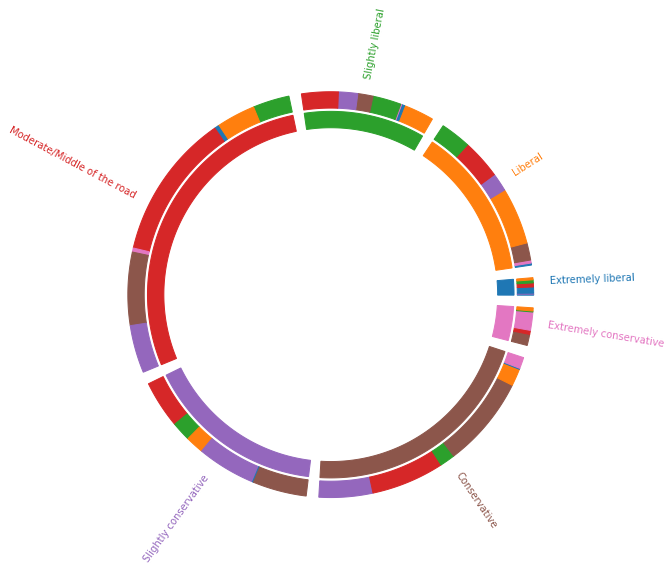

In [96]:
data = chord_diagram(categories="Qq49", pair="FAMID", layout_args={'spacing': 0.01, 'no_chords':True},
              data=df)

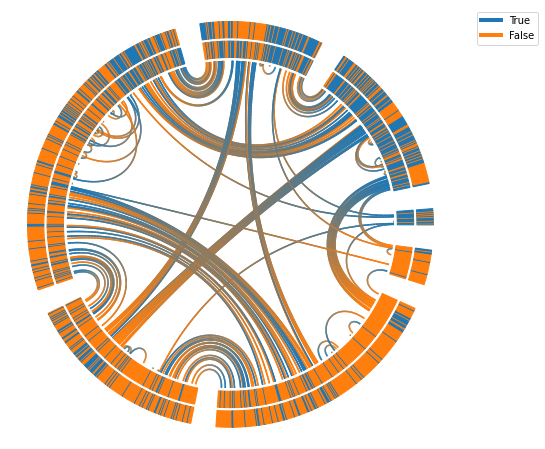

In [97]:

data["Qq2"] = data["Qq2"].astype('str').fillna("NaN")
data["Qqq2"] = data["Qq2"].apply(lambda x: 'disapprove' in x)
colored_chords(data, pair="FAMID", categories="Qq49", hue="Qqq2", layout_args={'spacing':0.02, 'subcircle': True})